<H1><b>Pertemuan 5 - Modern Convolutional Neural Network</b></H1>

<H3>Nama : Akmal Zuhdy Prasetya</H3>
<H3>NIM  : H071191035</H3>
<H5>Berdasarkan: <a>http://d2l.ai/chapter_convolutional-modern/index.html<a><H5>

In [1]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.filterwarnings('ignore')

# **1. Deep CNN (AlexNet)**

## **1.1 Introduction**

AlexNet, which employed an 8-layer CNN, won the ImageNet Large Scale Visual Recognition Challenge 2012 by a phenomenally large margin. This network showed, for the first time, that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision.

The design philosophies of AlexNet and LeNet are very similar, but there are also significant differences. First, AlexNet is much deeper than the comparatively small LeNet5. AlexNet consists of eight layers: five convolutional layers, two fully-connected hidden layers, and one fully-connected output layer. Second, AlexNet used the ReLU instead of the sigmoid as its activation function. Let us delve into the details below.

### **1.1.1 Architecture**

In AlexNet’s first layer, the convolution window shape is **11x11**. Since most images in ImageNet are more than ten times higher and wider than the MNIST images, objects in ImageNet data tend to occupy more pixels. Consequently, a larger convolution window is needed to capture the object. The convolution window shape in the second layer is reduced to **5x5**, followed by **3x3**. In addition, after the first, second, and fifth convolutional layers, the network adds maximum pooling layers with a window shape of **3x3** and a stride of 2. Moreover, AlexNet has ten times more convolution channels than LeNet.

After the last convolutional layer there are two fully-connected layers with 4096 outputs. These two huge fully-connected layers produce model parameters of nearly 1 GB. Due to the limited memory in early GPUs, the original AlexNet used a dual data stream design, so that each of their two GPUs could be responsible for storing and computing only its half of the model. Fortunately, GPU memory is comparatively abundant now, so we rarely need to break up models across GPUs these days (our version of the AlexNet model deviates from the original paper in this aspect).

### **1.1.2 Activation Functions**

Besides, AlexNet changed the sigmoid activation function to a simpler ReLU activation function. On one hand, the computation of the ReLU activation function is simpler. For example, it does not have the exponentiation operation found in the sigmoid activation function. On the other hand, the ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that backpropagation cannot continue to update some of the model parameters. In contrast, the gradient of the ReLU activation function in the positive interval is always 1. Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, so that the model cannot be effectively trained.

### **1.1.3 Capacity Control & Preprocessing**

AlexNet controls the model complexity of the fully-connected layer by dropout, while LeNet only uses weight decay. To augment the data even further, the training loop of AlexNet added a great deal of image augmentation, such as flipping, clipping, and color changes. This makes the model more robust and the larger sample size effectively reduces overfitting.

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10))

We construct a single-channel data example with both height and width of 224 to observe the output shape of each layer.

In [4]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## **1.2 Reading Dataset**

Although AlexNet is trained on ImageNet in the paper, we use Fashion-MNIST here since training an ImageNet model to convergence could take hours or days even on a modern GPU. One of the problems with applying AlexNet directly on Fashion-MNIST is that its images have lower resolution (**28x28** pixels) than ImageNet images. To make things work, we upsample them to **224x224** (generally not a smart practice, but we do it here to be faithful to the AlexNet architecture). We perform this resizing with the resize argument in the `d2l.load_data_fashion_mnist` function.

In [5]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

## **1.3 Training**

Now, we can start training AlexNet. Compared with LeNet, the main change here is the use of a smaller learning rate and much slower training due to the deeper and wider network, the higher image resolution, and the more costly convolutions.

loss 0.328, train acc 0.880, test acc 0.877
1450.4 examples/sec on cuda:0


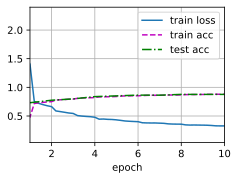

In [6]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# **2. Networks Using Blocks (VGG)**

While AlexNet offered empirical evidence that deep CNNs can achieve good results, it did not provide a general template to guide subsequent researchers in designing new networks. In the following sections, we will introduce several heuristic concepts commonly used to design deep networks.

Progress in this field mirrors that in chip design where engineers went from placing transistors to logical elements to logic blocks. Similarly, the design of neural network architectures had grown progressively more abstract, with researchers moving from thinking in terms of individual neurons to whole layers, and now to blocks, repeating patterns of layers.

The idea of using blocks first emerged from the Visual Geometry Group (VGG) at Oxford University, in their eponymously-named VGG network. It is easy to implement these repeated structures in code with any modern deep learning framework by using loops and subroutines.

## **2.1 VGG Blocks**

The basic building block of classic CNNs is a sequence of the following: (i) a convolutional layer with padding to maintain the resolution, (ii) a nonlinearity such as a ReLU, (iii) a pooling layer such as a maximum pooling layer. One VGG block consists of a sequence of convolutional layers, followed by a maximum pooling layer for spatial downsampling. In the original VGG paper [Simonyan & Zisserman, 2014], the authors employed convolutions with **3x3** kernels with padding of 1 (keeping height and width) and **2x2** maximum pooling with stride of 2 (halving the resolution after each block). In the code below, we define a function called `vgg_block` to implement one VGG block.

In [7]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

## **2.2 VGG Network**

Like AlexNet and LeNet, the VGG Network can be partitioned into two parts: the first consisting mostly of convolutional and pooling layers and the second consisting of fully-connected layers.

The original VGG network had 5 convolutional blocks, among which the first two have one convolutional layer each and the latter three contain two convolutional layers each. The first block has 64 output channels and each subsequent block doubles the number of output channels, until that number reaches 512. Since this network uses 8 convolutional layers and 3 fully-connected layers, it is often called VGG-11.

In [9]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [10]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

Next, we will construct a single-channel data example with a height and width of 224 to observe the output shape of each layer.

In [11]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


As we can see, we halve height and width at each block, finally reaching a height and width of 7 before flattening the representations for processing by the fully-connected part of the network.

## **2.3 Training**

Since VGG-11 is more computationally-heavy than AlexNet we construct a network with a smaller number of channels. This is more than sufficient for training on Fashion-MNIST.

In [12]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

Apart from using a slightly larger learning rate, the model training process is similar to that of AlexNet.

loss 0.171, train acc 0.937, test acc 0.923
748.7 examples/sec on cuda:0


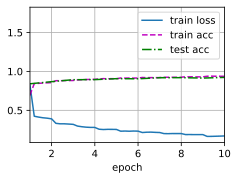

In [13]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# **3. Network in Network (NiN)**

## **3.1 NiN Blocks**

LeNet, AlexNet, and VGG all share a common design pattern: extract features exploiting spatial structure via a sequence of convolution and pooling layers and then post-process the representations via fully-connected layers. The improvements upon LeNet by AlexNet and VGG mainly lie in how these later networks widen and deepen these two modules. Alternatively, one could imagine using fully-connected layers earlier in the process. However, a careless use of dense layers might give up the spatial structure of the representation entirely, network in network (NiN) blocks offer an alternative.

In [14]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## **3.2 NiN Model**

Recall that the inputs and outputs of convolutional layers consist of four-dimensional tensors with axes corresponding to the example, channel, height, and width. Also recall that the inputs and outputs of fully-connected layers are typically two-dimensional tensors corresponding to the example and feature. The idea behind NiN is to apply a fully-connected layer at each pixel location (for each height and width). If we tie the weights across each spatial location, we could think of this as a convolutional layer or as a fully-connected layer acting independently on each pixel location. Another way to view this is to think of each element in the spatial dimension (height and width) as equivalent to an example and a channel as equivalent to a feature.

In [15]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # There are 10 label classes
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # Transform the four-dimensional output into two-dimensional output with a
    # shape of (batch size, 10)
    nn.Flatten())

We create a data example to see the output shape of each block.

In [16]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## **3.3 Training**

As before we use Fashion-MNIST to train the model. NiN’s training is similar to that for AlexNet and VGG.

loss 0.572, train acc 0.778, test acc 0.775
1019.5 examples/sec on cuda:0


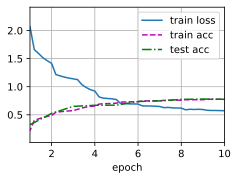

In [17]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# **4. Networks with Parallel Concatenations (GoogLeNet)**

In 2014, GoogLeNet won the ImageNet Challenge, proposing a structure that combined the strengths of NiN and paradigms of repeated blocks. One focus of the paper was to address the question of which sized convolution kernels are best. After all, previous popular networks employed choices as small as and as large as . One insight in this paper was that sometimes it can be advantageous to employ a combination of variously-sized kernels. In this section, we will introduce GoogLeNet, presenting a slightly simplified version of the original model: we omit a few ad-hoc features that were added to stabilize training but are unnecessary now with better training algorithms available.

## **4.1 GoogLeNet Model**

In [18]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

GoogLeNet uses a stack of a total of 9 inception blocks and global average pooling to generate its estimates. Maximum pooling between inception blocks reduces the dimensionality. The first module is similar to AlexNet and LeNet. The stack of blocks is inherited from VGG and the global average pooling avoids a stack of fully-connected layers at the end.

We can now implement GoogLeNet piece by piece. The first module uses a 64-channel 7x7 convolutional layer.

In [19]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The second module uses two convolutional layers: first, a 64-channel 1x1 convolutional layer, then a 3x3 convolutional layer that triples the number of channels.

In [20]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series.

In [21]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fourth module is more complicated. It connects five Inception blocks in series.

In [22]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fifth module has two Inception blocks.

In [23]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

The GoogLeNet model is computationally complex, so it is not as easy to modify the number of channels as in VGG. To have a reasonable training time on Fashion-MNIST, we reduce the input height and width from 224 to 96. This simplifies the computation. The changes in the shape of the output between the various modules are demonstrated below.

In [24]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## **4.2 Training**

As before, we train our model using the Fashion-MNIST dataset. We transform it to 96x96 pixel resolution before invoking the training procedure.

loss 0.241, train acc 0.908, test acc 0.879
1243.7 examples/sec on cuda:0


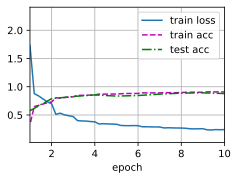

In [25]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# **5. Batch Normalization**

Training deep neural networks is difficult. And getting them to converge in a reasonable amount of time can be tricky. Together with residual blocks—covered batch normalization has made it possible for practitioners to routinely train networks with over 100 layers.

## **5.1 Implementation from Scratch**

Below, we implement a batch normalization layer with tensors from scratch.

In [26]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

We can now create a proper `BatchNorm` layer. Our layer will maintain proper parameters for scale gamma and shift beta, both of which will be updated in the course of training. Additionally, our layer will maintain moving averages of the means and variances for subsequent use during model prediction.

Putting aside the algorithmic details, note the design pattern underlying our implementation of the layer. Typically, we define the mathematics in a separate function, say `batch_norm`. We then integrate this functionality into a custom layer, whose code mostly addresses bookkeeping matters, such as moving data to the right device context, allocating and initializing any required variables, keeping track of moving averages (here for mean and variance), and so on. This pattern enables a clean separation of mathematics from boilerplate code. Also note that for the sake of convenience we did not worry about automatically inferring the input shape here, thus we need to specify the number of features throughout. Do not worry, the high-level batch normalization APIs in the deep learning framework will care of this for us and we will demonstrate that later.

In [27]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## **5.2 Applying Batch Normalization in LeNet**

To see how to apply `BatchNorm` in context, below we apply it to a traditional LeNet model. Recall that batch normalization is applied after the convolutional layers or fully-connected layers but before the corresponding activation functions.

In [28]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

As before, we will train our network on the Fashion-MNIST dataset. This code is virtually identical to that when we first trained LeNet. The main difference is the larger learning rate.

loss 0.267, train acc 0.902, test acc 0.890
22493.7 examples/sec on cuda:0


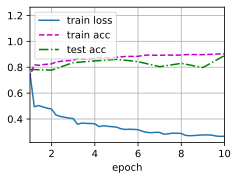

In [29]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Let us have a look at the scale parameter gamma and the shift parameter beta learned from the first batch normalization layer.

In [30]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.6714, 4.5536, 2.0868, 0.5066, 3.0504, 3.0452], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 1.1181, -2.5656, -2.1330,  1.0391, -3.1439, -0.5907], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

## **5.3 Concise Implementation**

Compared with the `BatchNorm` class, which we just defined ourselves, we can use the BatchNorm class defined in high-level APIs from the deep learning framework directly. The code looks virtually identical to our implementation above.

In [31]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

Below, we use the same hyperparameters to train our model. Note that as usual, the high-level API variant runs much faster because its code has been compiled to C++ or CUDA while our custom implementation must be interpreted by Python.

loss 0.265, train acc 0.901, test acc 0.836
32034.2 examples/sec on cuda:0


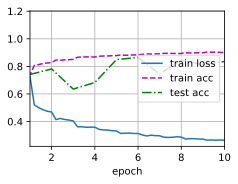

In [32]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# **6. Residual Networks (ResNet)**

As we design increasingly deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network. Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different. To make some progress we need a bit of mathematics.

## **6.1 Residual Blocks**

ResNet follows VGG’s full 3x3 convolutional layer design. The residual block has two 3x3 convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional 1x1 convolutional layer to transform the input into the desired shape for the addition operation. Let us have a look at the code below.

In [33]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever use_1x1conv=False, and one where we adjust channels and resolution by means of a convolution before adding.

Now let us look at a situation where the input and output are of the same shape.

In [34]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

We also have the option to halve the output height and width while increasing the number of output channels.

In [35]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## **6.2 ResNet Model**

The first two layers of ResNet are the same as those of the GoogLeNet we described before: 7x7 the convolutional layer with 64 output channels and a stride of 2 is followed by the 3x3 maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet uses four modules made up of Inception blocks. However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

Now, we implement this module. Note that special processing has been performed on the first module.

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module.

In [ ]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

Finally, just like GoogLeNet, we add a global average pooling layer, followed by the fully-connected layer output.

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

There are 4 convolutional layers in each module (excluding the 1x1 convolutional layer). Together with the first 7x7 convolutional layer and the final fully-connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18. By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet’s structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet.

Before training ResNet, let us observe how the input shape changes across different modules in ResNet. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

## **6.3 Training**

We train ResNet on the Fashion-MNIST dataset, just like before.

In [35]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# **7. Densely Connected Networks (DenseNet)**

ResNet significantly changed the view of how to parametrize the functions in deep networks. DenseNet (dense convolutional network) is to some extent the logical extension of this.

## **7.1 Dense Blocks**

DenseNet uses the modified “batch normalization, activation, and convolution” structure of ResNet. First, we implement this convolution block structure.

In [36]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

A dense block consists of multiple convolution blocks, each using the same number of output channels. In the forward propagation, however, we concatenate the input and output of each convolution block on the channel dimension.

In [37]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In the following example, we define a DenseBlock instance with 2 convolution blocks of 10 output channels. When using an input with 3 channels, we will get an output with 3+2x10=23 channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the growth rate.

In [38]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## **7.2 Transition Layers**

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A transition layer is used to control the complexity of the model. It reduces the number of channels by using the convolutional layer and halves the height and width of the average pooling layer with a stride of 2, further reducing the complexity of the model.

In [39]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

Apply a transition layer with 10 channels to the output of the dense block in the previous example. This reduces the number of output channels to 10, and halves the height and width.

In [40]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## **7.3 DenseNet Model**

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and maximum pooling layer as in ResNet.

In [41]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Then, similar to the four modules made up of residual blocks that ResNet uses, DenseNet uses four dense blocks. Similar to ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18 model. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels.

In [42]:
# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

Similar to ResNet, a global pooling layer and a fully-connected layer are connected at the end to produce the output.

In [43]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

## **7.4 Training**

Since we are using a deeper network here, in this section, we will reduce the input height and width from 224 to 96 to simplify the computation.

loss 0.138, train acc 0.950, test acc 0.908
1989.1 examples/sec on cuda:0


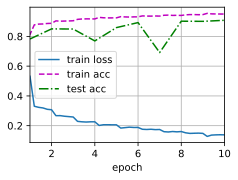

In [44]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())